# Data Analysis Report 

#### First we need to understand the type of data we are dealing with before we choose an appropriate recommender system model to deal with the data. We need to identify factors that influence movie rentals for users. Let's take a look at the data.

In [1]:
# Load Datasets
import pandas as pd

ratings = pd.read_csv("Camille G data/ratings.csv")
tags = pd.read_csv("Camille G data/tags.csv")
movies = pd.read_csv("Camille G data/movies.csv")
links = pd.read_csv("Camille G data/links.csv")

#### The TMDB metadata is in the TMDB folder so we need to retrieve all of the data into a dataframe before we can use that metadata. We skip the 862.0.json file since it is an empty file accidentally included.



In [2]:
import json
import glob

# Read data in tmdb file
folder_path = 'Camille G data/tmdb'
data = []
for file in glob.glob(f"{folder_path}/*.json"):
    try:
        with open(file, 'r') as f:
            json_data = json.load(f)
            json_data['filename'] = file.split('/')[-1]
            data.append(json_data)
    except json.JSONDecodeError:
        print(f"Skipping file due to JSONDecodeError: {file}")
    except Exception as e:
        print(f"Skipping file due to an unexpected error: {file}, Error: {e}")

tmdb_info = pd.DataFrame(data)

Skipping file due to JSONDecodeError: Camille G data/tmdb/862.0.json


#### Now we can take a look at the data, let's see the movies dataset first

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [5]:
movies["movieId"].nunique()

9742

#### We see there are 9742 movies, let's extract some additional features for the year and set of genres



In [6]:
movies['year'] = movies['title'].str.extract('\((\d{4})\)')
movies.head()

<>:1: SyntaxWarning: invalid escape sequence '\('
<>:1: SyntaxWarning: invalid escape sequence '\('
/var/folders/hl/vklcdg513pq3wbjh_c3_v4yr0000gn/T/ipykernel_18782/641375113.py:1: SyntaxWarning: invalid escape sequence '\('
  movies['year'] = movies['title'].str.extract('\((\d{4})\)')


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [7]:
movies[movies["year"].isna()]

,movieId,title,genres,year
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


In [8]:
movies[movies["title"].isna()]

,movieId,title,genres,year


In [9]:
movies[movies["title"] == ""]

,movieId,title,genres,year


In [10]:
movies[movies["genres"].isna()]

,movieId,title,genres,year


In [11]:
movies[movies["genres"] == ""]

,movieId,title,genres,year


#### Some movies are missing the year in this dataset, movies with no genre are listed as (no genre listed). Let's extract the genres

In [12]:
genre_counts = movies['genres'].str.split('|', expand=True).stack().value_counts()

In [13]:
genre_counts = pd.DataFrame(genre_counts)
genre_counts

,count
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978
Fantasy,779


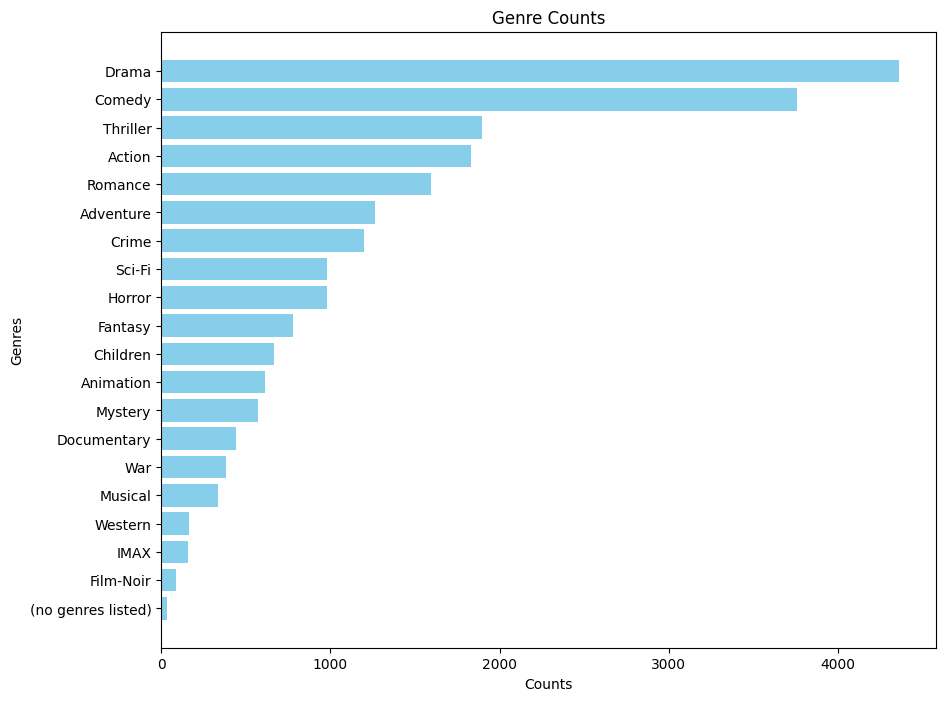

In [14]:
import matplotlib.pyplot as plt
# Plotting the data
plt.figure(figsize=(10, 8))
plt.barh(genre_counts.index, genre_counts['count'], color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Genres')
plt.title('Genre Counts')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

#### We see there is a power law distribution for the genre counts. Now let's look at the years.

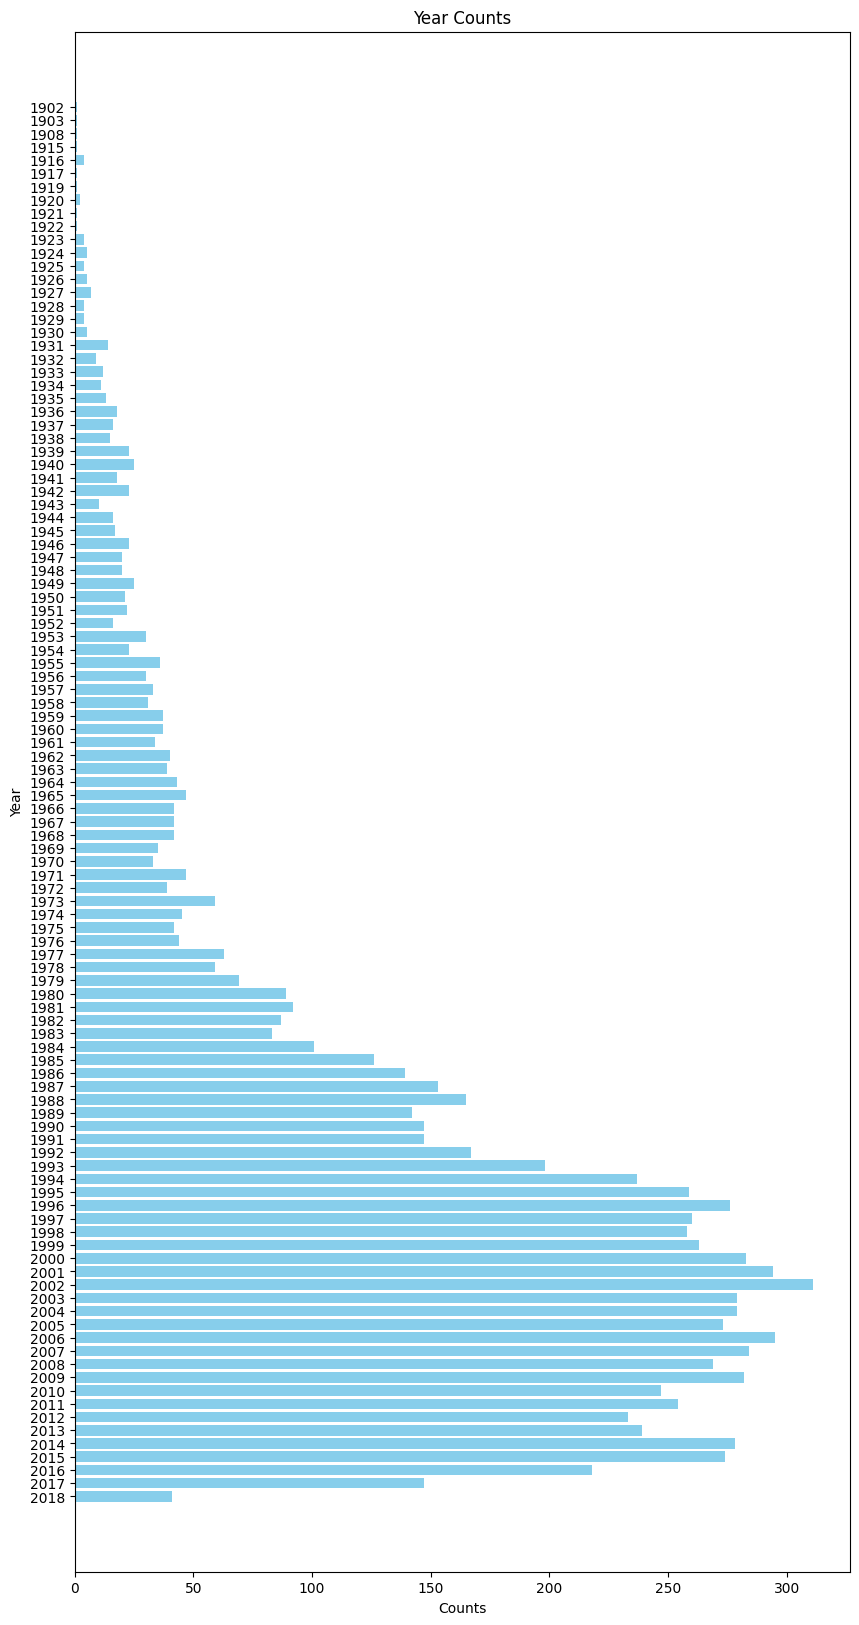

In [15]:
movie_years = pd.DataFrame(movies["year"].value_counts().sort_index())

plt.figure(figsize=(10, 20))
plt.barh(movie_years.index, movie_years['count'], color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Year')
plt.title('Year Counts')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

#### Some old movies are included but mostly concentrated in recent times up to 2018, let's look at tmdb

In [16]:
tmdb_info

,overview,popularity,original_title,runtime,release_date,vote_average,vote_count,status,tagline,spoken_languages,cast,id,filename
0,"The second ""visual album"" (a collection of sho...",8.738,Lemonade,65,2016-04-23,8.497,147,Released,,en,Beyoncé|Jay-Z|Serena Williams|Zendaya|Quvenzha...,394269,394269.json
1,"Set in 1929, a political boss and his advisor ...",17.518,Miller's Crossing,115,1990-09-21,7.455,1496,Released,"Up is down, black is white, and nothing is wha...",en|ga|it|yi,Gabriel Byrne|Albert Finney|Jon Polito|Marcia ...,379,379.json
2,A student's premonition of a deadly rollercoas...,40.900,Final Destination 3,93,2006-02-09,6.081,3549,Released,This ride will be the death of you.,en,Mary Elizabeth Winstead|Ryan Merriman|Kris Lem...,9286,9286.json
3,"On Christmas Eve, three homeless people living...",21.095,東京ゴッドファーザーズ,93,2003-12-29,7.895,1076,Released,Meet the ultimate dysfunctional family.,en|ja|es,Aya Okamoto|Yoshiaki Umegaki|Tohru Emori|Satom...,13398,13398.json
4,A wily old codger matches wits with the King o...,12.456,Darby O'Gill and the Little People,93,1959-06-24,6.700,130,Released,A touch O'Blarney... a heap O'Magic and A LOAD...,ga|en,Albert Sharpe|Janet Munro|Sean Connery|Jimmy O...,18887,18887.json
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9616,"In 1980s Italy, a relationship begins between ...",47.008,Call Me by Your Name,132,2017-09-01,8.165,11418,Released,Is it better to speak or die?,fr|en|it,Timothée Chalamet|Armie Hammer|Michael Stuhlba...,398818,398818.json
9617,An American journalist arrives in Berlin just ...,11.197,The Good German,108,2006-12-15,5.700,284,Released,"If war is Hell, then what comes after?",zh|de|ru|en,George Clooney|Cate Blanchett|Tobey Maguire|Be...,182,182.json
9618,Admiral Frank Beardsley returns to New London ...,16.539,"Yours, Mine & Ours",90,2005-11-23,6.150,777,Released,"18 kids, one house, no way.",en,Dennis Quaid|Rene Russo|Sean Faris|Danielle Pa...,13499,13499.json
9619,With their father away as a chaplain in the Ci...,20.062,Little Women,115,1994-12-21,7.287,1120,Released,The story that has lived in our hearts for gen...,en|de|fr,Winona Ryder|Gabriel Byrne|Trini Alvarado|Sama...,9587,9587.json


In [17]:
tmdb_info.describe()

,popularity,runtime,vote_average,vote_count,id
count,9621.000000,9621.000000,9621.000000,9621.000000,9621.000000
mean,17.822001,104.337491,6.511031,1462.063715,53897.586114
std,17.636767,24.449488,0.866277,2922.864527,92231.062813
min,0.600000,2.000000,0.000000,0.000000,2.000000
25%,8.769000,92.000000,6.000000,128.000000,9622.000000
50%,13.503000,102.000000,6.564000,409.000000,16325.000000
75%,21.083000,115.000000,7.115000,1374.000000,43423.000000
max,679.514000,583.000000,8.917000,34704.000000,525662.000000


#### We see TMDB includes various additional metadata about the movies runtime, tagline, cast etc. Since this info may be useful, we will want to join it with our movies dataframe and save, to do this we will check the links dataframe

In [18]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


#### We see links gives us the mapping from movieId to tmdbID, let's use that

In [19]:
combined_movies_links = pd.merge(movies, links, on='movieId')
movie_full_df = pd.merge(combined_movies_links, tmdb_info, left_on='tmdbId', right_on="id", how='left')

In [20]:
movie_full_df.columns

Index(['movieId', 'title', 'genres', 'year', 'imdbId', 'tmdbId', 'overview',
       'popularity', 'original_title', 'runtime', 'release_date',
       'vote_average', 'vote_count', 'status', 'tagline', 'spoken_languages',
       'cast', 'id', 'filename'],
      dtype='object')

In [21]:
movie_full_df.describe()

,movieId,imdbId,tmdbId,popularity,runtime,vote_average,vote_count,id
count,9742.000000,9.742000e+03,9734.000000,9622.000000,9622.000000,9622.000000,9622.000000,9622.000000
mean,42200.353623,6.771839e+05,55162.123793,17.821801,104.338391,6.511052,1462.020266,53892.495115
std,52160.494854,1.107228e+06,93653.481487,17.635862,24.448377,0.866234,2922.715730,92227.621494
min,1.000000,4.170000e+02,2.000000,0.600000,2.000000,0.000000,0.000000,2.000000
25%,3248.250000,9.518075e+04,9665.500000,8.769000,92.000000,6.000000,128.000000,9621.250000
50%,7300.000000,1.672605e+05,16529.000000,13.504500,102.000000,6.564000,409.500000,16322.500000
75%,76232.000000,8.055685e+05,44205.750000,21.081000,115.000000,7.114750,1374.000000,43414.250000
max,193609.000000,8.391976e+06,525662.000000,679.514000,583.000000,8.917000,34704.000000,525662.000000


In [22]:
movie_full_df.to_csv("Camille G data/movies_combined.csv", header=True)

#### Now we have a combined dataset with all the movies metadata so far. Let's check out ratings and tags now

In [23]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [24]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [25]:
# check at least 20 ratings per user
ratings.groupby("userId").count().describe()

,movieId,rating,timestamp
count,610.000000,610.000000,610.000000
mean,165.304918,165.304918,165.304918
std,269.480584,269.480584,269.480584
min,20.000000,20.000000,20.000000
25%,35.000000,35.000000,35.000000
50%,70.500000,70.500000,70.500000
75%,168.000000,168.000000,168.000000
max,2698.000000,2698.000000,2698.000000


In [26]:
ratings.groupby("userId").count()

,movieId,rating,timestamp
userId,,,
1,232,232,232
2,29,29,29
3,39,39,39
4,216,216,216
5,44,44,44
...,...,...,...
606,1115,1115,1115
607,187,187,187
608,831,831,831


In [27]:
ratings.nunique()

userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64

In [28]:
# Distribution of rating counts
pd.DataFrame(ratings.groupby(["rating"]).size()).reset_index().rename({0: "count"}, axis=1)

,rating,count
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550
5,3.0,20047
6,3.5,13136
7,4.0,26818
8,4.5,8551
9,5.0,13211


#### We see the ratings dataset gives us the users rating of each movie that they rated, and the time that they rated that movie, this will be very helpful to create a dataset for our recomendation system regardless of the algorithm we use. Now check tags:

In [29]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [30]:
tags.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


In [31]:
tags.nunique()

userId         58
movieId      1572
tag          1589
timestamp    3411
dtype: int64

In [32]:
# Most active users
tags["userId"].value_counts().head()

userId
474    1507
567     432
62      370
599     323
477     280
Name: count, dtype: int64

In [33]:
# Most common tags
tags['tag'].value_counts().head(10)

tag
In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
funny                 23
surreal               23
Disney                23
religion              22
sci-fi                21
quirky                21
Name: count, dtype: int64

In [34]:
tags.groupby("userId").count().describe()

,movieId,tag,timestamp
count,58.000000,58.000000,58.000000
mean,63.500000,63.500000,63.500000
std,215.118103,215.118103,215.118103
min,1.000000,1.000000,1.000000
25%,2.250000,2.250000,2.250000
50%,4.000000,4.000000,4.000000
75%,13.000000,13.000000,13.000000
max,1507.000000,1507.000000,1507.000000


#### We see some users dominate the tagging and the most common tag names. Now from the ratings and tags, it may be useful to have additional features for our movies in case we use the content features in our model, so an average rating (from our user ratings) and tags features may be useful, let's create these and save

In [35]:
ratings_features = ratings.groupby('movieId').agg(
    average_rating=('rating', 'mean'),
    rating_count=('rating', 'count'),
    rating_std=('rating', 'std')
).reset_index()
ratings_features

,movieId,average_rating,rating_count,rating_std
0,1,3.920930,215,0.834859
1,2,3.431818,110,0.881713
2,3,3.259615,52,1.054823
3,4,2.357143,7,0.852168
4,5,3.071429,49,0.907148
...,...,...,...,...
9719,193581,4.000000,1,NaN
9720,193583,3.500000,1,NaN
9721,193585,3.500000,1,NaN
9722,193587,3.500000,1,NaN


In [36]:
tag_counts = tags.groupby(['movieId', 'tag']).size().unstack(fill_value=0)
tag_counts

tag,"""artsy""",06 Oscar Nominated Best Movie - Animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001-like,...,women,wonderwoman,workplace,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
184471,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
movie_full_ratings_features = movie_full_df.merge(ratings_features, on="movieId")


In [38]:
movie_features_df = movie_full_ratings_features.merge(tag_counts.add_prefix("tag_"), on="movieId", how="left")

In [39]:
movie_features_df.head()

,movieId,title,genres,year,imdbId,tmdbId,overview,popularity,original_title,runtime,...,tag_women,tag_wonderwoman,tag_workplace,tag_writing,tag_wrongful imprisonment,tag_wry,tag_younger men,tag_zither,tag_zoe kazan,tag_zombies
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",100.954,Toy Story,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,113497,8844.0,When siblings Judy and Peter discover an encha...,13.981,Jumanji,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,113228,15602.0,A family wedding reignites the ancient feud be...,12.686,Grumpier Old Men,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,114885,31357.0,"Cheated on, mistreated and stepped on, the wom...",11.945,Waiting to Exhale,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,1995,113041,11862.0,Just when George Banks has recovered from his ...,19.558,Father of the Bride Part II,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
movie_features_df.to_csv("Camille G data/movies_combined_all_features.csv", header=True)

#### Let's look at the data a little more to check for correlations and useful features

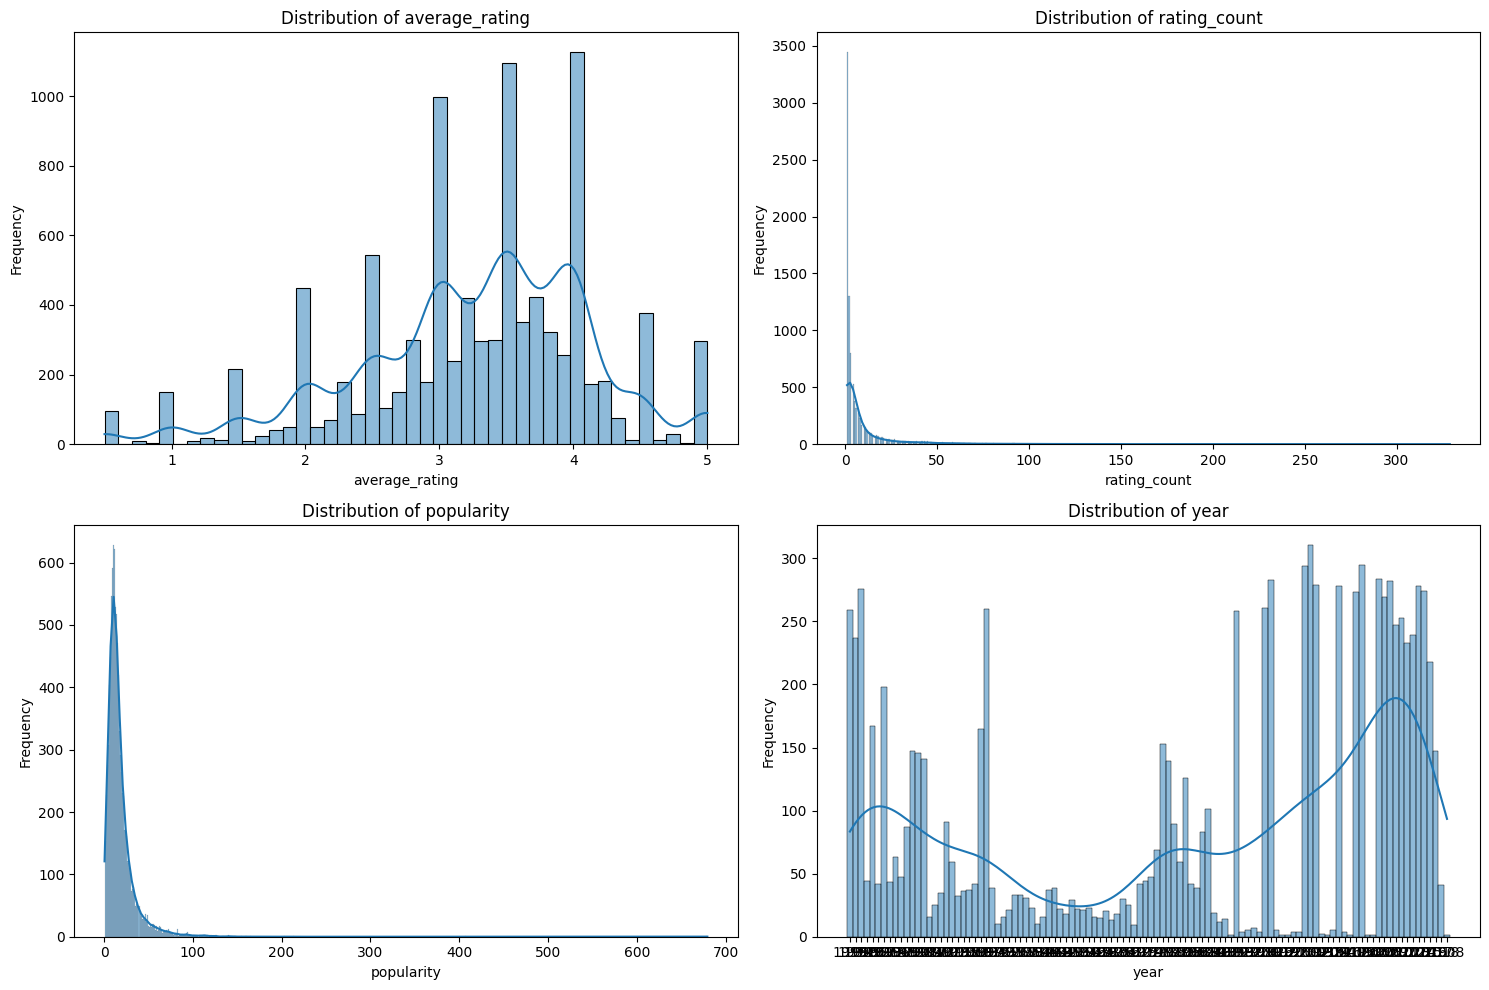

In [41]:
import seaborn as sns
columns_for_visualization = ['average_rating', 'rating_count', 'popularity', 'year']

# Plotting distributions of selected columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, col in enumerate(columns_for_visualization):
    sns.histplot(movie_features_df[col], ax=axes[i//2, i%2], kde=True)
    axes[i//2, i%2].set_title(f'Distribution of {col}')
    axes[i//2, i%2].set_ylabel('Frequency')
    axes[i//2, i%2].set_xlabel(col)

plt.tight_layout()
plt.show()

#### We can see that the average rating is skewed to higher numbers, most movies don't have many ratings, a few movies a high popularity, and there are somewhat more movies over time with a little lesser movies in more recent years

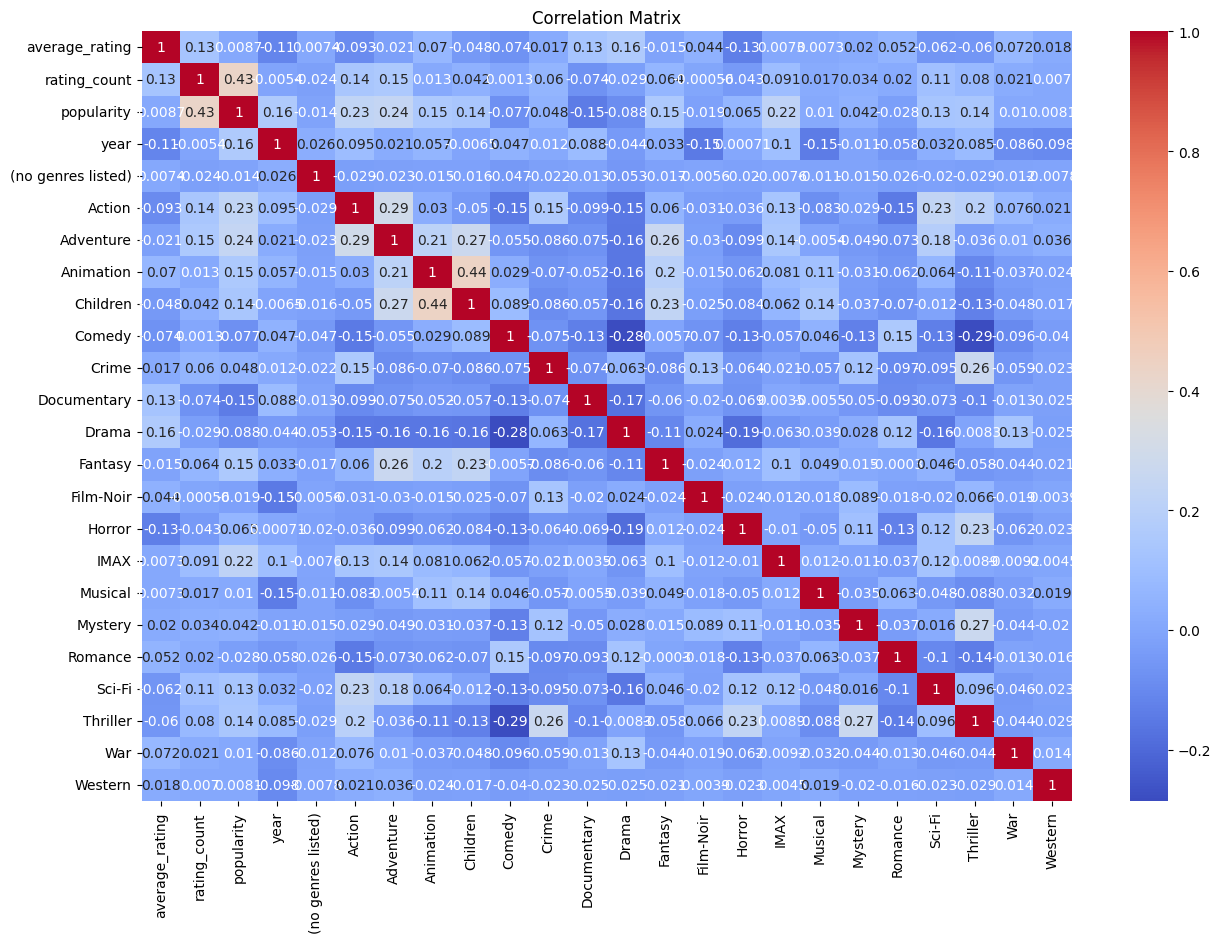

In [42]:
import numpy as np

# Selecting subset for correlation analysis
# Include numerical features
selected_columns = ['average_rating', 'rating_count', 'popularity', 'year']

# Splitting the genres string into individual genres and creating dummy variables
genre_dummies = movie_features_df['genres'].str.get_dummies(sep='|')
selected_data = pd.concat([movie_features_df[selected_columns], genre_dummies], axis=1)

# Calculate correlations
correlation_matrix = selected_data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### The correlation matrix shows that average_rating and rating_count are slightly correlated, implying movies with more ratings have more reviews. Popularity and rating count are highly correlated, because popular movies have many reviews. The Year feature shows slight correlations with popularity, implying popular movies tend to have better ratings in some cases. We can see the correlations between genres as well, for example between crime and thriller. This data tells us that reducing the dimensionality with techniques like PCA may help in reducing the dimensionality, and that many of these features may be useful for predicting whether a user will rent a movie.

#### We could potentially do a lot more analysis on this dataset in the future, with additional techniques like user behavior analysis, cluster analysis, analyzing dimensionality reduction techniques and plots, but this analysis is sufficient for continuing to the next step of creating an initial model for this dataset.